# Towards a standardized provenance information format for ESGF / WPS tools, services et al.
## Birdhouse WPS Joint Workshop (IS-ENES, Convergence, CLIPC, EUCLEIA)
## Version 0.1 - S. Kindermann, 16. Okt. 2015 (coding sprint developments)


Status: 
* Most evaluation tool effors (like ESMValTool and Climaf) provide information about the provenance of generated results
* The format and content is different
* In ESMValTool the provenance log generating parts are spread all over the source code --> no simple prov API integration for the near future --> translation of prof log end results to standard W3C prov format

    > *Info from Axel*:
    > point where file informations is collected:
    * reformat_scripts/defaults/reformat_default_main.ncl
    * reformat_scripts/defaults/reformat_default_func.ncl (read_var , apply_fixes)
    * reformat_scripts/constants.ncl (write_output)
    * interface_scripts/messaging.ncl (main, write_header, write_flist, write_references)
    * interface_scripts/data_handling.ncl (main, add_data_var, read_data)
    * other info is written in indiv. diagnosis (ncl) scripts and collected by the wrappers

Steps forward: 
* Generate W3C Prov standard conformant provenance descriptions - these can then be stored / exchanged / queried as well as combined using standard and generic tools
* Generate translation tools for ESMValTool provenance log output to W3C Prov (seriazable to json and xml)
* Provide a simple python API to generate provenance files (based on W3C Prov)

## Installation of W3C PROV standard python library

To install the prov library using [pip](http://pip.pypa.io/) with support for graphical exports:
```bash
pip install prov[dot]
```
Code Repository: https://github.com/trungdong/prov

Documentation: http://prov.readthedocs.org/en/latest/


# Two ways to generate prov documents: 
# -- API 
# -- translation of log files


## 1) Simple demo API (v0.1) 

### to demonstrate an API for use case specific prov document generation

Parameters In:
* list of input elements (e.g. files)
* list of generated output elements
* generting_process (tool, wps)
* author (agent info)

Result:
* python prov element, which can be serialized (into W3C Prov standardized json and xml), printed and visualized
dictionary (using specific keys from a CV) with provenance information--> prov document

In [95]:
## ToDo: improve and write tests

from prov.model import ProvDocument
from IPython.display import Image

def generate_prov(input_files, output_files, generating_process, author):
    '''
    Generates Prov model entities and prov model relationships between them
    
    output python prov instance which can be serialized/de-serialized based on json 

    '''
    d1 = ProvDocument()
    # Namespaces should be imported from a central place 
    # e.g. a simple controled vocab server, or github later
    d1.add_namespace('enes', 'http://www.enes.org/enes_entitiy/')
    d1.add_namespace('file', 'http://www.enes.org/enes_entity/file/')
    d1.add_namespace('user', 'http://www.enes.org/enes_entity/user/')
    d1.add_namespace('esgf', 'http://carbon.dkrz.de/file/cmip5/')
    d1.add_namespace('enes_data', 'http://enes_org/enes_data#')
    d1.add_namespace('dc','http://dublin-core.org/')
    d1.add_namespace('workflow', 'http://www.enes.org/enes/workflow/#')
    
    inputs = []
    for i,entry in enumerate(input_files):
        inputs.append(d1.entity(entry['name'], entry['properties']))

    outputs = []
    for i,entry in enumerate(output_files):
        outputs.append(d1.entity(entry['name'], entry['properties']))
    
    processor = d1.activity(generating_process['name'])

    the_agent = d1.agent(author['name'])
    
    # AttributedTo relationships
    for i,entry in enumerate(output_files):
      d1.wasAttributedTo(outputs[i],author['name'] )

    # wasDerivedFrom relationships
    for i,out_entry in enumerate(output_files):
        for j,in_entry in enumerate(input_files):
            d1.wasDerivedFrom(out_entry['name'], in_entry['name'])
            
    # used and wasGeneratedBy relationships
    for i, in_entry in enumerate(input_files):
        d1.used(generating_process['name'], in_entry['name'])
    
    for j, out_entry in enumerate(output_files):
        d1.wasGeneratedBy(out_entry['name'], generating_process['name'])   
        
    return d1 

def visualize_prov(prov_doc):
    from prov.dot import prov_to_dot
    from IPython.display import Image
    dot = prov_to_dot(prov_doc)
    dot.write_png('tmp1.png')
    dot.write_pdf('tmp1.pdf')
    
    return Image('tmp1.png')
    

In [82]:
# Example input, output and tool/WPS process as well as agent

input_files = [{'name':'esgf:cmip5.mpi-m.tas.v1', 
                'properties': {'prov:label': 'experiment-mpi-m', 
                               'prov:type': 'Dataset', 
                               'dc:title':"eval_series_1"}},
               {'name':'esgf:cmip5.miroc.tas.v1', 
                'properties': {'prov:label': 'experiment-miroc', 
                               'prov:type': 'Dataset', 
                               'dc:title':"eval_series_1"}}
             ]
output_files = [{'name':'enes:temporal-mean-result1-v1.nc',
                 'properties':{'dc:title':'eval_series_1_1'}}
               ]
generating_process = {'name':'workflow:temporal-mean-cdo',
                      'properties':{'prov:label': 'experiment-mpi-m', 
                                    'prov:type': 'enes_data:Dataset', 
                                    'dc:title':'esmval-analysis-a1'}
                                   }
author = {'name':'enes:Stephan Kindermann'}

In [72]:
# generate example provenance object
prov_doc = generate_prov(input_files,output_files,generating_process,author)

In [73]:
# print serialized provenance object
print prov_doc.get_provn()

document
  prefix enes <http://www.enes.org/enes_entitiy/>
  prefix workflow <http://www.enes.org/enes/workflow/#>
  prefix dc <http://dublin-core.org/>
  prefix user <http://www.enes.org/enes_entity/user/>
  prefix file <http://www.enes.org/enes_entity/file/>
  prefix esgf <http://carbon.dkrz.de/file/cmip5/>
  prefix enes_data <http://enes_org/enes_data#>
  
  entity(esgf:cmip5.mpi-m.tas.v1, [prov:type="Dataset", dc:title="eval_series_1", prov:label="experiment-mpi-m"])
  entity(esgf:cmip5.miroc.tas.v1, [prov:type="Dataset", dc:title="eval_series_1", prov:label="experiment-miroc"])
  entity(enes:temporal-mean-result1-v1.nc, [dc:title="eval_series_1_1"])
  activity(workflow:temporal-mean-cdo, -, -)
  agent(enes:Stephan Kindermann)
  wasAttributedTo(enes:temporal-mean-result1-v1.nc, enes:Stephan Kindermann)
  wasDerivedFrom(enes:temporal-mean-result1-v1.nc, esgf:cmip5.mpi-m.tas.v1, -, -, -)
  wasDerivedFrom(enes:temporal-mean-result1-v1.nc, esgf:cmip5.miroc.tas.v1, -, -, -)
  used(workf

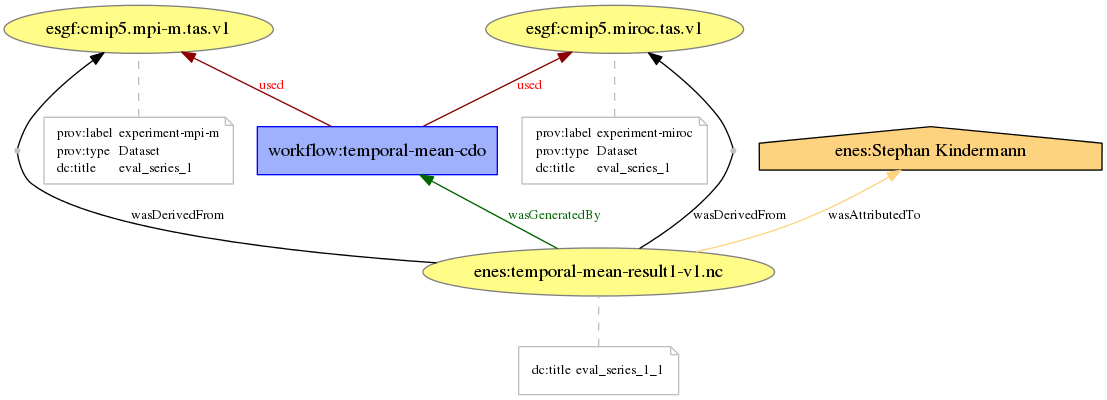

In [83]:
# visualize
visualize_prov(prov_doc)

## PROV-JSON export

[PROV-JSON](https://provenance.ecs.soton.ac.uk/prov-json/) is natively supported by the library and is the default serialisation format.

In [ ]:
# serialize / desirialize
serialized_version = prov_doc.serialize()
print serialized_version

In [75]:
print prov_doc.serialize(indent=2)

{
  "wasDerivedFrom": {
    "_:id3": {
      "prov:usedEntity": "esgf:cmip5.miroc.tas.v1", 
      "prov:generatedEntity": "enes:temporal-mean-result1-v1.nc"
    }, 
    "_:id2": {
      "prov:usedEntity": "esgf:cmip5.mpi-m.tas.v1", 
      "prov:generatedEntity": "enes:temporal-mean-result1-v1.nc"
    }
  }, 
  "used": {
    "_:id5": {
      "prov:entity": "esgf:cmip5.miroc.tas.v1", 
      "prov:activity": "workflow:temporal-mean-cdo"
    }, 
    "_:id4": {
      "prov:entity": "esgf:cmip5.mpi-m.tas.v1", 
      "prov:activity": "workflow:temporal-mean-cdo"
    }
  }, 
  "wasAttributedTo": {
    "_:id1": {
      "prov:entity": "enes:temporal-mean-result1-v1.nc", 
      "prov:agent": "enes:Stephan Kindermann"
    }
  }, 
  "agent": {
    "enes:Stephan Kindermann": {}
  }, 
  "entity": {
    "enes:temporal-mean-result1-v1.nc": {
      "dc:title": "eval_series_1_1"
    }, 
    "esgf:cmip5.miroc.tas.v1": {
      "dc:title": "eval_series_1", 
      "prov:type": "Dataset", 
      "prov:label":

You can also serialize the document directly to a file by providing a filename (below) or a Python File object.

In [76]:
prov_doc.serialize('esgf-prov.json')

A PROV-JSON file can also be deserialised into a `ProvDocument` instance as follows.

In [77]:
d2 = ProvDocument.deserialize('esgf-prov.json')
prov_doc == d2  # Is it the same document we saved earlier?

True

# 2) translation of tool log file
## Example transformation of ESMValTool log file into provenace document

In [96]:
## initial version of simple log file parser
## requires small changes to current log file format of esmval tools
## Input: esmvaltool log file
## Output: [tool_prov,authors_prov,contributer_prov,project_prov,agent,output_files] (all entities have assigned namespace prefixes)

def add_entry(my_dict,my_key, my_entry):
    if my_key in my_dict.keys():
        my_dict[my_key].append(my_entry)
    else:
        my_dict[my_key]=[my_entry]  


import re
bracket_number = re.compile('\(\d*\)')

fh = open('refs-acknows_SeaIce-small.txt')
#fh = open('refs-acknows_SeaIce.txt')
# namespaces: enes,enes_data, model_data, obs_data, user, esgf, esmval_diag, var, path
# initialize dictionaries for tools, data, authors, etc. 

tool_prov = {} # tools --> input data
#path_prov = {} # tools --> path(s)
authors_prov = {} # tools --> authors
contributers_prov = {} # tools --> contributers
projects_prov = {} # tools --> projects
#model_prov = {} # tools --> model(s)
#var_prov = {} # tools --> variables
# context of a file entry:
# tool_name, variable, model, path
# in this context: files 

for line in fh.readlines(): 
    line_list = line.rsplit()
    #print line
    #print line_list
    if line_list != []:
        if line_list[0] == "===": 
            tool_name = "esmval_diag:"+line_list[1]
        if line_list[0] == "Variable:":
            variable_name = "var:"+line_list[1]
            #print line
            #add_entry(var_prov,tool_name,variable_name)
        if line_list[0] == "Model:":
            model_name = "model:"+line_list[1]
            #add_entry(model_prov,tool_name,model_name)
        if line_list[0] == "Input" and line_list[1] == "path:":
            path_name = "path:"+line_list[2]
            #add_entry(path_prov,tool_name,"path:"+path_name)
        if line_list[0] == "-A-":
            add_entry(authors_prov,tool_name,line)
        if line_list[0] == "-C-":
            add_entry(contributers_prov,tool_name,line)
        if line_list[0] == "-P-":
            add_entry(projects_prov,tool_name,line)
        if bracket_number.match(line_list[0]): 
            add_entry(tool_prov,tool_name,["model_data:"+line_list[1],variable_name,model_name,path_name])

    ## not yet extracted from log
agent = {'name':'enes:Axel Lauer'}
output_files = [{'id':'enes:dummy.nc',
                'properties':{'dc:title':'eval_series_1_1'}}]



In [97]:
from prov.model import ProvDocument
from IPython.display import Image


d1 = ProvDocument()

#namespaces: enes,enes_data, model_data, obs_data, user, esgf, esmval_diag, var, path
d1.add_namespace('enes', 'http://www.enes.org/enes_entitiy/')
d1.add_namespace('enes_data', 'http://enes_org/enes_data#')
d1.add_namespace('model_data', 'http://www.enes.org/modeldata/')
d1.add_namespace('obs_data', 'http://www.enes.org/observationsdata/')
d1.add_namespace('user', 'http://www.enes.org/enes_entity/user/')
d1.add_namespace('esgf', 'http://carbon.dkrz.de/file/cmip5/')
d1.add_namespace('path','http://www.esmval.org/data/path#')
d1.add_namespace('cache','http://www.esmval.org/data/cache/')
d1.add_namespace('dc','http://dublin-core.org/')
d1.add_namespace('esmval_diag', 'http://www.esmval.org/tool/')  # just examples, esmval-related namespaces tbd 



data_items=[]
for key,value in tool_prov.iteritems():   
    tool = d1.activity(key)
    for [data_item,variable_name,model_name,path_name] in value:
        
        if data_item not in data_items:
             data_items.append(data_item)
             data_properties = {'enes:variable':variable_name,
                                'enes:model':model_name,
                                'cache:path':path_name
                                }
             file_object = d1.entity(data_item)
             file_object.add_attributes(data_properties)
            
    for [data_item,variable_name,model_name,path_name] in value:    
        d1.used(tool, data_item)
    #tool.add_attributes(value['properties'])
    tool.set_time('2015-10-16:15:00','2015-10-16:16:00')
    #print tool
    for out_entry in output_files:
        d1.wasGeneratedBy(out_entry['id'],key)

d1.agent(agent['name'])
for entry in output_files:
      d1.wasAttributedTo(entry['id'],agent['name'] )

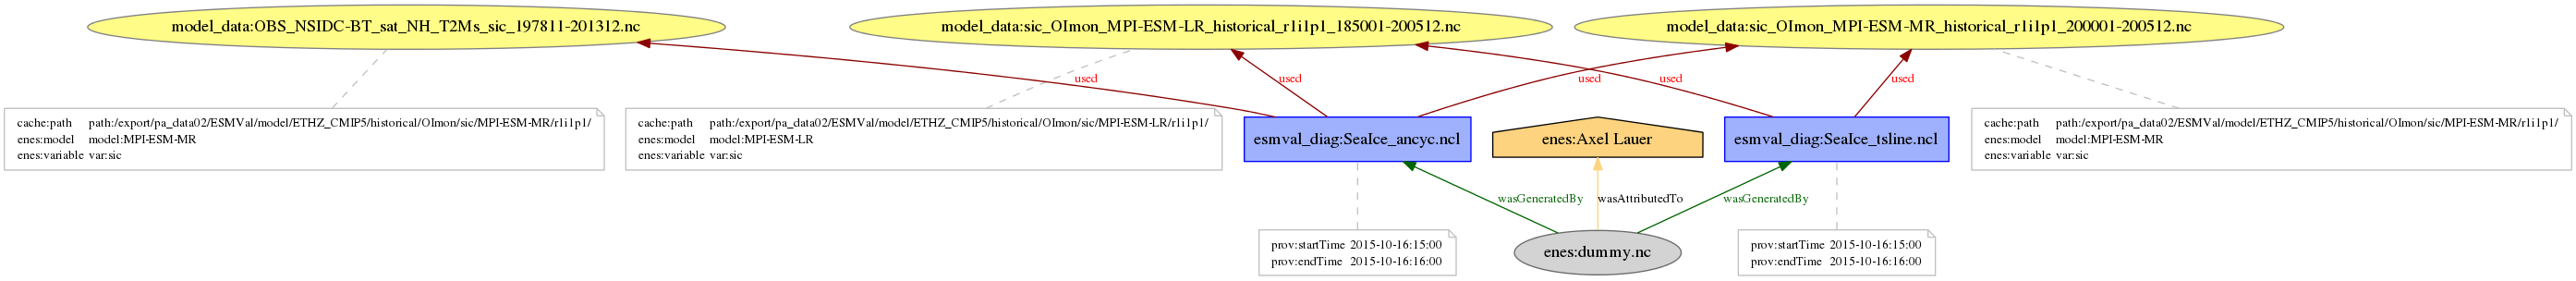

In [98]:
visualize_prov(d1)

In [ ]:
# Configure ProvStore API Wrapper with your API Key
from provstore.api import Api
# see your API key at https://provenance.ecs.soton.ac.uk/store/account/developer/
api = Api(username='your ProvStore username', api_key='your API key')

##  Store and retrieve provenance documents 

Having the created a provenance document, you can upload it to [ProvStore](https://provenance.ecs.soton.ac.uk/store/), a free repository for provenance documents, to share it publicly/privately, or simple just to store and retrieve it back at a later time.
Another possibility is to register provenance documents in the birdhous CSW catalog.

## Further reading


If you want to find out more about how to use the library and ProvStore, here are some references:
* [Prov Python library's documentation](http://prov.readthedocs.org)
* [ProvStore's API documentation](https://provenance.ecs.soton.ac.uk/store/help/api/)
* [Overview of the PROV standards](http://www.w3.org/TR/prov-overview/)


<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" href="http://purl.org/dc/dcmitype/InteractiveResource" property="dct:title" rel="dct:type"> This notebook</span> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.